V3 computes test_loss for various train set sizes.

### Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys

import elegy as eg
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

jnp.arange(0)  # Prints out any jax warnings.

DeviceArray([], dtype=int32)

In [2]:
sys.path.append("..")

import src.experiments.mlp_scaling as mlp_scaling

### Configure experiment

In [3]:
INPUT_SHAPE = (2,)
LAYER_WIDTHS = (96, 192, 1024, 42, 5, 1)
#LAYER_WIDTHS = (96, 192, 1)
N_TEST = 2048

TEACHER_MOD = mlp_scaling.MLP(
    input_shape=INPUT_SHAPE,
    layer_widths=LAYER_WIDTHS,
)

STUDENT_MOD = mlp_scaling.MLP(
    input_shape=INPUT_SHAPE,
    layer_widths=LAYER_WIDTHS,
)

### Initialize teacher + create test set

┏━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ path     ┃ module   ┃ params                                ┃ Parameter        ┃
┡━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ *        │ MLP()    │                                       │                  │
├──────────┼──────────┼───────────────────────────────────────┼──────────────────┤
│ .linear  │ Linear() │ bias: Parameter(96)           float32 │ 288      1.2KB   │
│          │          │ kernel: Parameter(2, 96)      float32 │                  │
├──────────┼──────────┼───────────────────────────────────────┼──────────────────┤
│ .linear2 │ Linear() │ bias: Parameter(192)          float32 │ 18,624   74.5KB  │
│          │          │ kernel: Parameter(96, 192)    float32 │                  │
├──────────┼──────────┼───────────────────────────────────────┼──────────────────┤
│ .linear3 │ Linear() │ bias: Parameter(1024)         float32 │ 197,632  790.5KB │
│          │          │ kernel: Parameter(192, 1024)  float32 │                  │
├──────────┼──────────┼───────────────────────────────────────┼──────────────────┤
│ .linear4 │ Linear() │ bias: Parameter(42)           float32 │ 43,050   172.2KB │
│          │          │ kernel: Parameter(1024, 42)   float32 │                  │
├──────────┼──────────┼───────────────────────────────────────┼──────────────────┤
│ .linear5 │ Linear() │ bias: Parameter(5)            float32 │ 215      860B    │
│          │          │ kernel: Parameter(42, 5)      float32 │                  │
├──────────┼──────────┼───────────────────────────────────────┼──────────────────┤
│ .linear6 │ Linear() │ bias: Parameter(1)            float32 │ 6        24B     │
│          │          │ kernel: Parameter(5, 1)       float32 │                  │
├──────────┼──────────┼───────────────────────────────────────┼──────────────────┤
│          │          │                                Total: │ 259,815  1.0MB   │
└──────────┴──────────┴───────────────────────────────────────┴──────────────────┘
                                                                                  
                         Total Parameters: 259,815  1.0MB                         

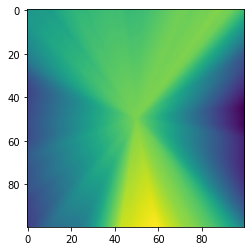

In [4]:
TEACHER = mlp_scaling.get_random_mlp(mlp=TEACHER_MOD, seed=-1)
DS_TEST = mlp_scaling.get_iid_dataset(
    model=TEACHER, n_samples=N_TEST, rng=jax.random.PRNGKey(-2)
)

mlp_scaling.viz_model(TEACHER, side_samples=100)
TEACHER.summary()

### Train student models

In [5]:
NS = [int(1.7 ** x) for x in range(1, 22)]
NS[:8], NS[-1]

([1, 2, 4, 8, 14, 24, 41, 69], 69091)

In [6]:
%%time
train_results = []

for n in NS:
    print(f"Training for {n=}")
    tr = mlp_scaling.train_student(
        student_mod=STUDENT_MOD,
        teacher=TEACHER,
        n_train_samples=n,
        ds_test=DS_TEST,
        seed=n,
    )
    
    train_results.append(tr)
    print(f"train_mse={tr.history.history['mean_squared_error_loss'][-1]}")
    print(f"val_mse  ={tr.history.history['val_mean_squared_error_loss'][-1]}")

Training for n=1
train_mse=0.006985158659517765
val_mse  =0.1860712319612503
Training for n=2
train_mse=0.18623417615890503
val_mse  =0.2760896682739258
Training for n=4
train_mse=0.06728669255971909
val_mse  =0.12359891831874847
Training for n=8
train_mse=0.07702139019966125
val_mse  =0.06762207299470901
Training for n=14
train_mse=0.0032779485918581486
val_mse  =0.006370240356773138
Training for n=24
train_mse=0.00515878526493907
val_mse  =0.005963888019323349
Training for n=41
train_mse=0.08689200133085251
val_mse  =0.08553972095251083
Training for n=69
train_mse=0.018704935908317566
val_mse  =0.016720935702323914
Training for n=118
train_mse=0.07226229459047318
val_mse  =0.0663842186331749
Training for n=201
train_mse=0.0010547523852437735
val_mse  =0.0006808136822655797
Training for n=342
train_mse=0.0016288963379338384
val_mse  =0.001687380368821323
Training for n=582
train_mse=0.0009463498136028647
val_mse  =0.0009530301904305816
Training for n=990
train_mse=1.609012542758137e-0

Text(0.5, 1.0, 'dim=(2,); TEACHER=(96, 192, 1024, 42, 5, 1); STUDENT=(96, 192, 1024, 42, 5, 1)')

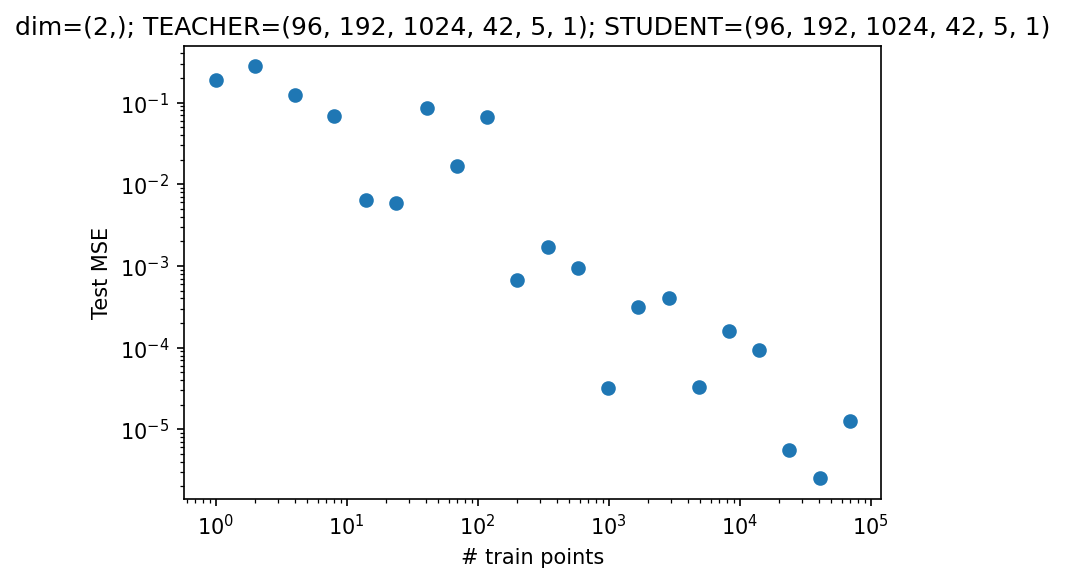

In [7]:
val_mses = [
    tr.history.history["val_mean_squared_error_loss"][-1] for tr in train_results
]

plt.figure(figsize=(6, 4), dpi=150)
plt.scatter(NS, val_mses)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Test MSE")
plt.xlabel("# train points")
plt.title(f"dim={INPUT_SHAPE}; TEACHER={LAYER_WIDTHS}; STUDENT={LAYER_WIDTHS}")

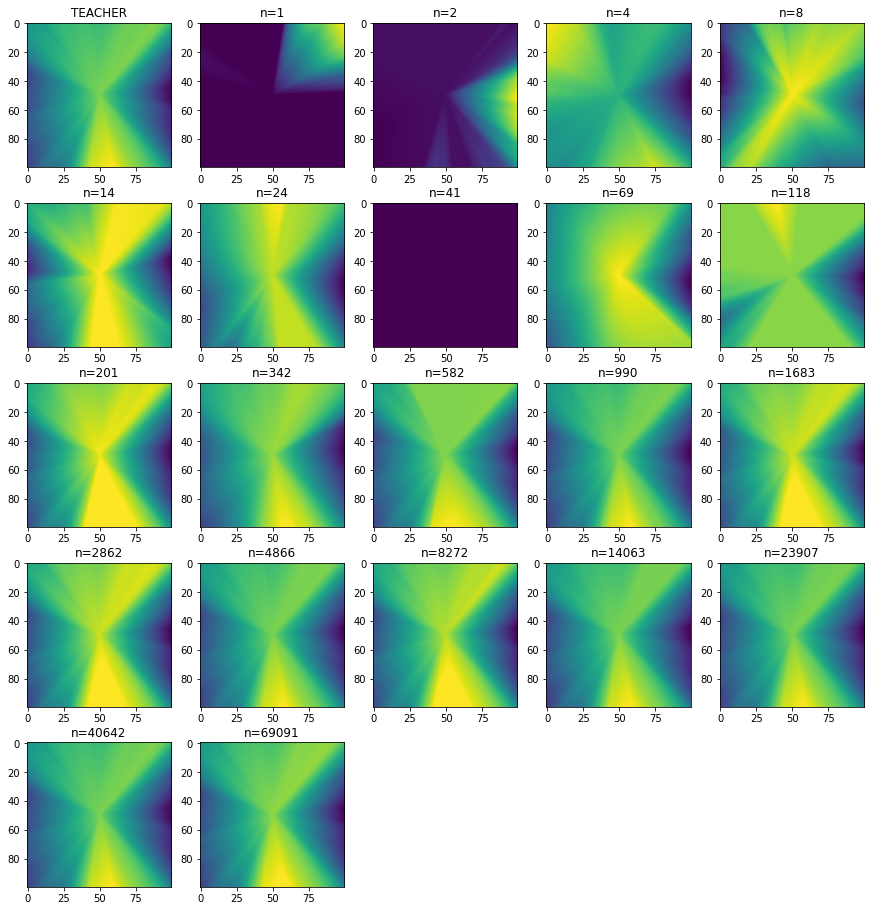

In [8]:
num_cols = 5
num_rows = len(NS) // num_cols + 1

plt.figure(figsize=(3 * num_cols, 3.2 * num_rows))

plt.subplot(num_rows, num_cols, 1)
mlp_scaling.viz_model(TEACHER, side_samples=100)
plt.title("TEACHER")

for i, n in enumerate(NS):
    plt.subplot(num_rows, num_cols, i + 2)
    mlp_scaling.viz_model(train_results[i].model, side_samples=100)
    plt.title(f"{n=}")

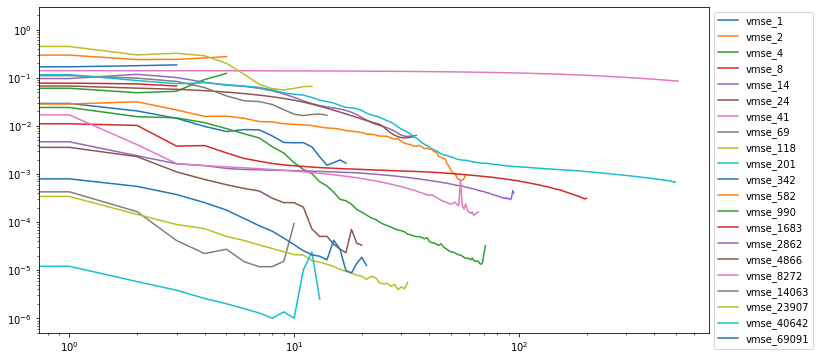

In [12]:
def plot_history(history):
    n_plots = 1
    #plt.figure(figsize=(14, 24))
    
    for i, key in enumerate(list(history.history.keys())[:n_plots]):
        metric = history.history[key]
        val_metric = history.history[f"val_{key}"]

        plt.subplot(n_plots, 1, i + 1)
        plt.plot(metric, label=f"Training {key}")
        plt.plot(val_metric, label=f"Validation {key}")
        plt.legend(loc="upper right")
        plt.ylabel(key)
        plt.title(f"Training and Validation {key}")
        plt.yscale("log")
    #plt.show()

    
plt.figure(figsize=(12, 6))
for tr, n in zip(train_results, NS):
    #plt.plot(tr.history.history['mean_squared_error_loss'], label=f"tmse_{n}")
    plt.plot(tr.history.history['val_mean_squared_error_loss'], label=f"vmse_{n}")
        
    
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.yscale("log")
plt.xscale("log")
           
           
#plt.figure(figsize=(12, 6))
#plot_history(train_results[9].history)
#plot_history(train_results[10].history)